In [2]:
import sys

In [3]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
cdir = '/content/drive/My Drive/Colab Notebooks/CS 146/PS1'
sys.path += [cdir] 
### ========== TODO : END ========== ###


In [5]:
from nutil import *

In [6]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [8]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        n = y.shape[0]
        self.probabilities_ = { label: count / n for label, count in Counter(y).most_common() }
        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        labels, probabilities = zip(*self.probabilities_.items())
        y = [np.random.choice(labels, p=probabilities) for i in range(X.shape[0])]
        ### ========== TODO : END ========== ###

        return y


In [9]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [10]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use train_test_split (be careful of the parameters)
    sss = StratifiedShuffleSplit(random_state=0, test_size=test_size, n_splits=ntrials)
    agg_test_err = 0
    agg_train_err = 0
    agg_f1 = 0
    for train_index, test_index in sss.split(X, y):
      # print(train_index, test_index)
      # print(X[train_index], y[train_index])
      clf.fit(X[train_index], y[train_index])
      predictions_train = clf.predict(X[train_index])
      predictions_test = clf.predict(X[test_index])
      agg_train_err += 1 - metrics.accuracy_score(y[train_index], predictions_train, normalize=True)
      agg_test_err += 1 - metrics.accuracy_score(y[test_index], predictions_test, normalize=True)
      agg_f1 += metrics.f1_score(y[test_index], predictions_test, average='micro')
    ### ========== TODO : END ========== ###
    
    return agg_train_err / ntrials, agg_test_err / ntrials, agg_f1 / ntrials


In [11]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Investigating various classifiers...
Finding the best k...
27 0.17300000000000004
Investigating depths...
optimal depth 5
Done


<Figure size 432x288 with 0 Axes>

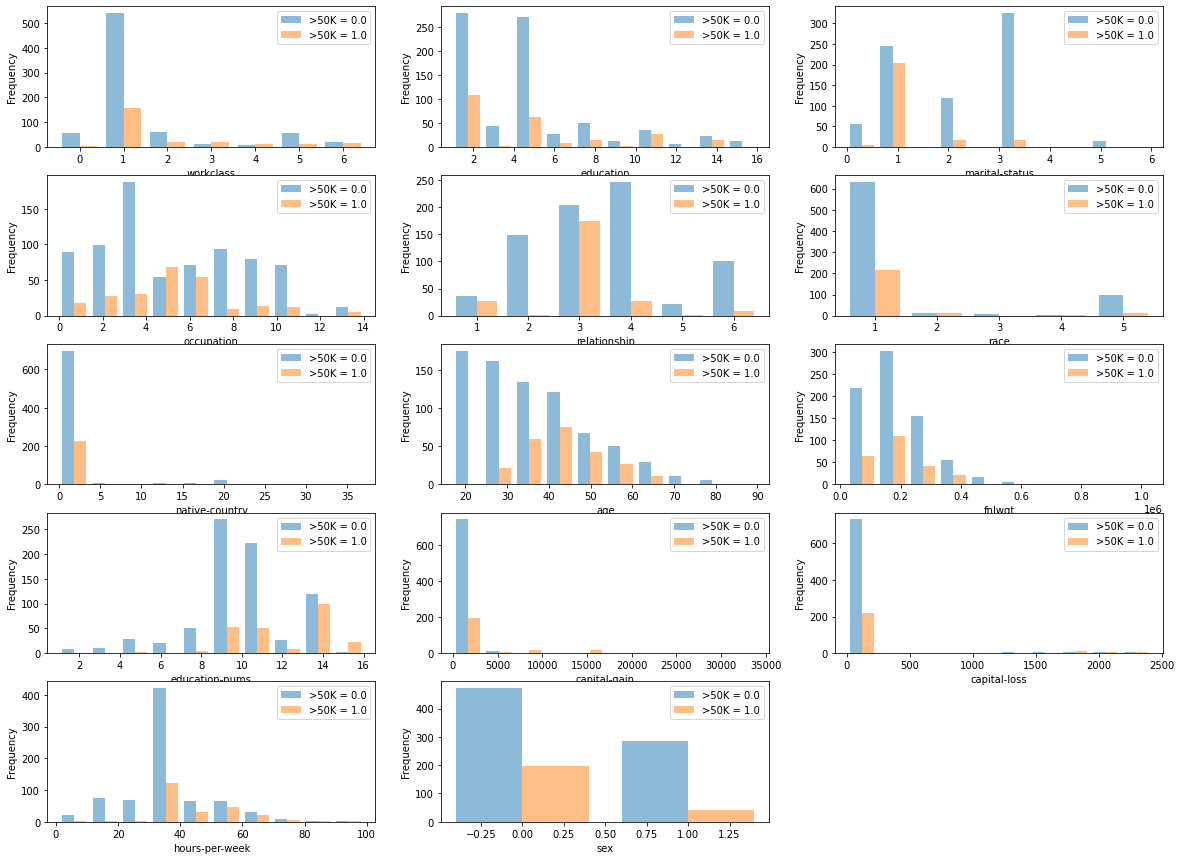

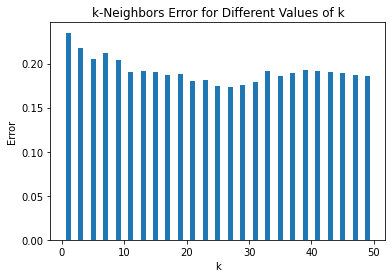

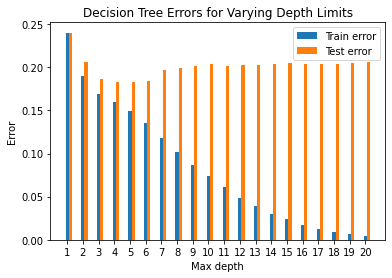

In [31]:

######################################################################
# main
######################################################################

def main():
    
    
    
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file = f"{cdir}/adult_subsample.csv"
    ### ========== TODO : END ========== ###
    



    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features

    

    plt.figure()
    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    




    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    X = StandardScaler().fit_transform(X)
    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    # print('Classifying using Majority Vote...')
    # clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    # clf.fit(X, y)                  # fit training data using the classifier
    # y_pred = clf.predict(X)        # take the classifier and run it on the training data
    # train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    # print('\t-- training error: %.3f' % train_error)





    # ### ========== TODO : START ========== ###
    # # part b: evaluate training error of Random classifier
    # print('Classifying using Random...')
    # clf = RandomClassifier()
    # clf.fit(X, y)
    # y_pred = clf.predict(X)
    # train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    # print('\t-- training error: %.3f' % train_error)

    # ### ========== TODO : END ========== ###





    # ### ========== TODO : START ========== ###
    # # part c: evaluate training error of Decision Tree classifier
    # print('Classifying using Decision Tree...')
    # clf = DecisionTreeClassifier(criterion='entropy')
    # clf.fit(X, y)
    # y_pred = clf.predict(X)
    # train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    # print('\t-- training error: %.3f' % train_error)
    # ### ========== TODO : END ========== ###






    # ### ========== TODO : START ========== ###
    # # part d: evaluate training error of k-Nearest Neighbors classifier
    # # use k = 3, 5, 7 for n_neighbors
    # for n_neighbors in (3, 5, 7):
    #   print(f'Classifying using k-Nearest Neighbors, k={n_neighbors}...')
    #   clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    #   clf.fit(X, y)
    #   y_pred = clf.predict(X)
    #   train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    #   print('\t-- training error: %.3f' % train_error)
    # # ### ========== TODO : END ========== ###





    # ### ========== TODO : START ========== ###
    # # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')
    # for clf in (MajorityVoteClassifier(), RandomClassifier(), DecisionTreeClassifier(criterion='entropy'), KNeighborsClassifier(n_neighbors=5)):
    #   print(f'{clf}:')
    #   train_error, test_error, test_f1 = error(clf, X, y)
    #   print(f'train error: {round(train_error, 3)}, test error: {round(test_error, 3)}, test f1: {round(test_f1, 3)}')
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    results = {}
    for i in range(1, 50):
      if i % 2:
        clf = KNeighborsClassifier(n_neighbors=i)
        scores = cross_val_score(clf, X, y=y, cv=10)
        mean_score = np.mean(scores)
        results[i] = 1 - mean_score
    fig = plt.figure()
    plt.bar(list(results.keys()), list(results.values()))
    plt.xlabel('k')
    plt.ylabel('Error')
    plt.title("k-Neighbors Error for Different Values of k")
    max_k = min(results.items(), key=lambda item : item[1])
    print(max_k[0], max_k[1])
    optimal_k = max_k[0]
    
        


    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    labels = np.array([i for i in range(1,21)])
    train_errs = np.empty(20)
    test_errs = np.empty(20)
    for i in range(1, 21):
      clf = DecisionTreeClassifier(criterion='entropy', max_depth=i)
      train_err, test_err, test_f1 = error(clf, X, y)
      train_errs[i-1] = train_err
      test_errs[i-1] = test_err
    fig = plt.figure()
    width = 0.2
    plt.bar(labels, train_errs, width=width, label="Train error")
    plt.bar(labels+width, test_errs, width=width, label="Test error")
    plt.xticks(np.arange(1, 21, 1.0))
    plt.xlabel('Max depth')
    plt.ylabel('Error')
    plt.title('Decision Tree Errors for Varying Depth Limits')
    plt.legend()
    optimal_depth = labels[list(test_errs).index(min(test_errs))]
    print('optimal depth', optimal_depth)
    ### ========== TODO : END ========== ###





    # optimal_depth = 5
    # optimal_k = 27
    # ### ========== TODO : START ========== ###
    # # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # clfs = (KNeighborsClassifier(n_neighbors=optimal_k), DecisionTreeClassifier(criterion='entropy', max_depth=optimal_depth))
    # labels = np.empty(10)
    # test_errs = [np.empty(10), np.empty(10)]
    # train_errs = [np.empty(10), np.empty(10)]
    # for i, train_size in enumerate(np.arange(0.1, 1.01, 0.1)):
    #   labels[i] = train_size
    #   train_errs[0][i], test_errs[0][i], _ = error(clfs[0], X, y)
    #   train_errs[1][i], test_errs[1][i], _ = error(clfs[1], X, y)
      
    # print(labels)
    # fig = plt.figure()
    # width = 0.001
    # plt.bar(labels, train_errs[0], width=width, label="Train error")
    # plt.bar(labels+width, test_errs[0], width=width, label="Test error")
    # plt.xticks(np.arange(0.1, 1.01, 0.1))
    # plt.legend()
    # plt.title("K Neighbors")
    
    # fig = plt.figure()
    # width = 0.001
    # plt.bar(labels, train_errs[1], width=width, label="Train error")
    # plt.bar(labels+width, test_errs[1], width=width, label="Test error")
    # plt.xticks(np.arange(0.1, 1.01, 0.1))
    # plt.legend()
    # plt.title("Decision tree")
    

    
    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()


In [25]:
def error_h(clf, X, y, data_usage) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """
    sss = StratifiedShuffleSplit(random_state=0, test_size=0.1, n_splits=1)
    for train_index, test_index in sss.split(X, y):
      X_train = X[train_index]
      X_test = X[test_index]
      y_train = y[train_index]
      y_test = y[test_index]

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use train_test_split (be careful of the parameters)
    end = int(X_train.shape[0]*data_usage)
    print(X_train.shape[0])
    print(data_usage)
    print(end)
    print()
    X_train = X_train[:end]
    y_train = y_train[:end]
    clf.fit(X_train, y_train)
    predictions_train = clf.predict(X_train)
    predictions_test = clf.predict(X_test)
    train_err = 1 - metrics.accuracy_score(y_train, predictions_train, normalize=True)
    test_err = 1 - metrics.accuracy_score(y_test, predictions_test, normalize=True)
    return train_err, test_err

In [32]:
data_file = f"{cdir}/adult_subsample.csv"
### ========== TODO : END ========== ###

data = load_data(data_file, header=1, predict_col=-1)

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
X = StandardScaler().fit_transform(X)
n,d = X.shape  # n = number of examples, d =  number of features
optimal_depth = 5
optimal_k = 15
### ========== TODO : START ========== ###
# part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
clfs = (KNeighborsClassifier(n_neighbors=optimal_k), DecisionTreeClassifier(criterion='entropy', max_depth=optimal_depth))
labels = np.empty(10)
test_errs = [np.empty(10), np.empty(10)]
train_errs = [np.empty(10), np.empty(10)]
for i, train_size in enumerate(np.arange(0.1, 1.01, 0.1)):
  labels[i] = train_size
  train_errs[0][i], test_errs[0][i] = error_h(clfs[0], X, y, train_size)
  train_errs[1][i], test_errs[1][i] = error_h(clfs[1], X, y, train_size)

900
0.1
90

900
0.1
90

900
0.2
180

900
0.2
180

900
0.30000000000000004
270

900
0.30000000000000004
270

900
0.4
360

900
0.4
360

900
0.5
450

900
0.5
450

900
0.6
540

900
0.6
540

900
0.7000000000000001
630

900
0.7000000000000001
630

900
0.8
720

900
0.8
720

900
0.9
810

900
0.9
810

900
1.0
900

900
1.0
900



[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.18888889 0.19444444 0.14444444 0.16111111 0.16       0.14259259
 0.15714286 0.16388889 0.1691358  0.16      ]


Text(0, 0.5, 'Error')

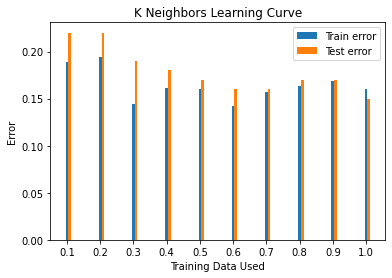

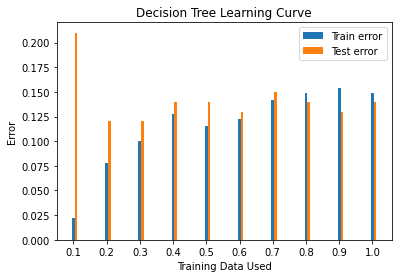

In [33]:
print(labels)
print(train_errs[0])
fig = plt.figure()
width = 0.008
plt.bar(labels, train_errs[0], width=width, label="Train error")
plt.bar(labels+width, test_errs[0], width=width, label="Test error")
plt.xticks(np.arange(0.1, 1.01, 0.1))
plt.legend()
plt.title("K Neighbors Learning Curve")
plt.xlabel("Training Data Used")
plt.ylabel("Error")

fig = plt.figure()
plt.bar(labels, train_errs[1], width=width, label="Train error")
plt.bar(labels+width, test_errs[1], width=width, label="Test error")
plt.xticks(np.arange(0.1, 1.01, 0.1))
plt.legend()
plt.title("Decision Tree Learning Curve")
plt.xlabel("Training Data Used")
plt.ylabel("Error")